In [1]:
pip install torch torchvision tqdm pillow scikit-learn umap-learn matplotlib ftfy regex git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/mh/h9wqwfm520lfxl6l4rwpcs4m0000gn/T/pip-req-build-40nk6sid
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/mh/h9wqwfm520lfxl6l4rwpcs4m0000gn/T/pip-req-build-40nk6sid
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'clip' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'clip'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369548 sha256=2a0a2a1bdd3aa93c71a82cf2136de92

In [23]:
pip install umap-learn


Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import torch
import clip
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoImageProcessor, ViTMAEModel
from PIL import Image
import requests
import torch
import torch.nn as nn
from transformers import ViTMAEModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from sklearn.neighbors import NearestNeighbors
import umap


In [ ]:

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

In [44]:


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")
    
    def forward(self, inputs):
        # Drop metadata if passed (like 'image_name')
        inputs.pop('image_name', None)

        outputs = self.model(**inputs)  
        # Mean over patch dimension -> [batch, hidden_dim]
        return torch.mean(outputs.last_hidden_state, dim=1)


In [45]:
pic_dir = "/Users/susenavenkateshnathan/Pictures/Images - AI Generated"

In [46]:
extractor = FeatureExtractor()

# Collect embeddings
embeddings = []
filenames = []

for fname in os.listdir(pic_dir):
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        img_path = os.path.join(pic_dir, fname)
        image = Image.open(img_path).convert("RGB")
        
        # Preprocess for ViT
        inputs = image_processor(images=image, return_tensors="pt")
        
        # Get features
        with torch.no_grad():
            feat = extractor(inputs)  # shape [1, hidden_dim]
        
        embeddings.append(feat.squeeze(0))  # remove batch dim
        filenames.append(fname)

# Stack into tensor
embeddings = torch.stack(embeddings)  # shape [N, hidden_dim]
print("Embeddings shape:", embeddings.shape)

Embeddings shape: torch.Size([32, 768])


In [57]:

# Initialize DBSCAN
# eps = neighborhood radius
# min_samples = how many neighbors are needed to form a dense region
dbscan = DBSCAN(eps=5.0, min_samples=2, metric="euclidean")

# Fit & predict clusters
labels = dbscan.fit_predict(embeddings.numpy())

# Show cluster assignment
for fname, label in zip(filenames, labels):
    print(f"{fname} -> Cluster {label}")

# -1 means "noise" (not assigned to any cluster)


DALL·E 2024-12-06 17.57.38 - A lavender-purple cyber cat that is cute, soft, and fluffy, with a glowing, futuristic aesthetic. The cat has a sleek but fluffy fur texture that emit.webp -> Cluster -1
Gemini_Generated_Image_rm63btrm63btrm63.jpeg -> Cluster 0
DALL·E 2024-10-01 16.19.13 - A realistic and majestic sunset in the mountains, reminiscent of a scene from Game of Thrones, without any dragons. The mountains are rugged, dark, an.webp -> Cluster 0
DALL·E 2024-09-01 13.16.33 - A cyber world at night, full of fascinating future technology. The cityscape is illuminated with vibrant purple, blue, and other futuristic lighting. .webp -> Cluster -1
Sujasa Eerie.jpg -> Cluster 0
17db6e0a-4d3c-460a-a36a-3b2b2db13dbf.webp -> Cluster 0
85197756-ef30-42b7-be3e-c317dcc03476.webp -> Cluster -1
DALL·E 2024-10-31 16.29.57 - A cute, fluffy cartoon cat designed to look like sushi. The cat has a playful, rounded body shape with light pastel fur that resembles rice. It has se.webp -> Cluster -1
DALL·E

In [58]:


# Set a fixed size for averaging
IMG_SIZE = (224, 224)

# Assume labels from DBSCAN or KMeans
unique_labels = set(labels)

for cluster_id in unique_labels:
    if cluster_id == -1:
        continue  # skip noise

    # Get images in this cluster
    cluster_imgs = [filenames[i] for i, l in enumerate(labels) if l == cluster_id]
    
    sum_img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    
    for fname in cluster_imgs:
        img_path = os.path.join(pic_dir, fname)
        img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
        sum_img += np.array(img, dtype=np.float32)
    
    mean_img = (sum_img / len(cluster_imgs)).astype(np.uint8)
    mean_img_pil = Image.fromarray(mean_img)
    
    mean_img_pil.show(title=f"Cluster {cluster_id} mean image")


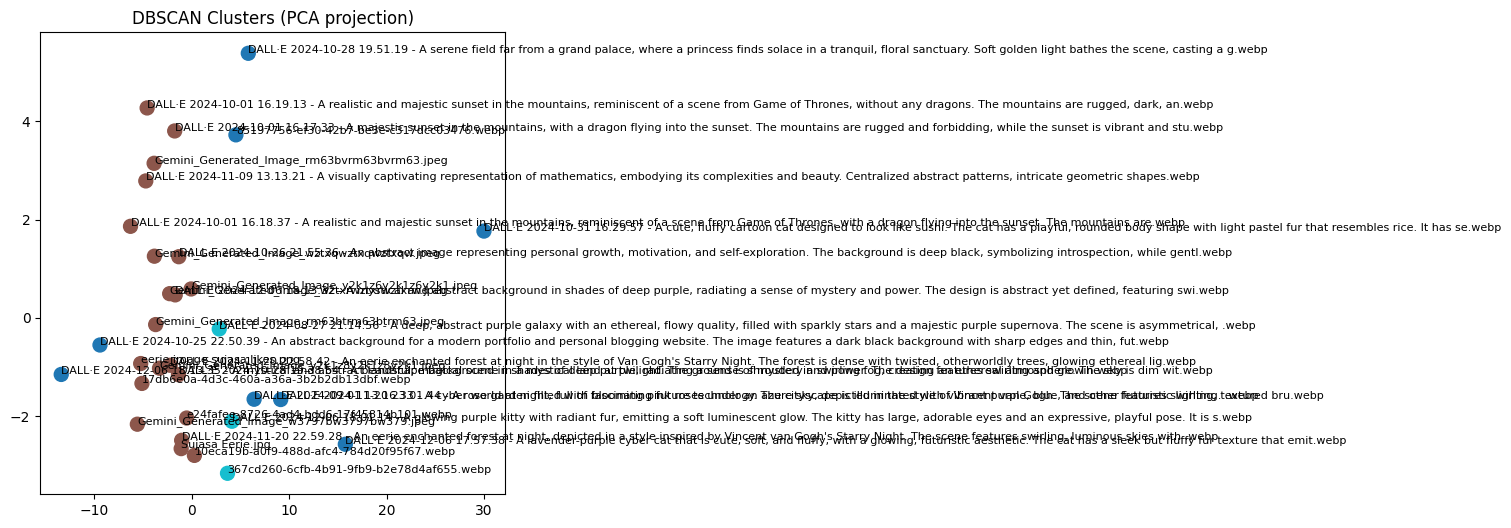

In [55]:

# PCA 2D
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings.numpy())

plt.figure(figsize=(6,6))
plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1], c=labels, cmap='tab10', s=100)
for i, fname in enumerate(filenames):
    plt.text(embeddings_2d_pca[i,0]+0.01, embeddings_2d_pca[i,1]+0.01, fname, fontsize=8)
plt.title("DBSCAN Clusters (PCA projection)")
plt.show()


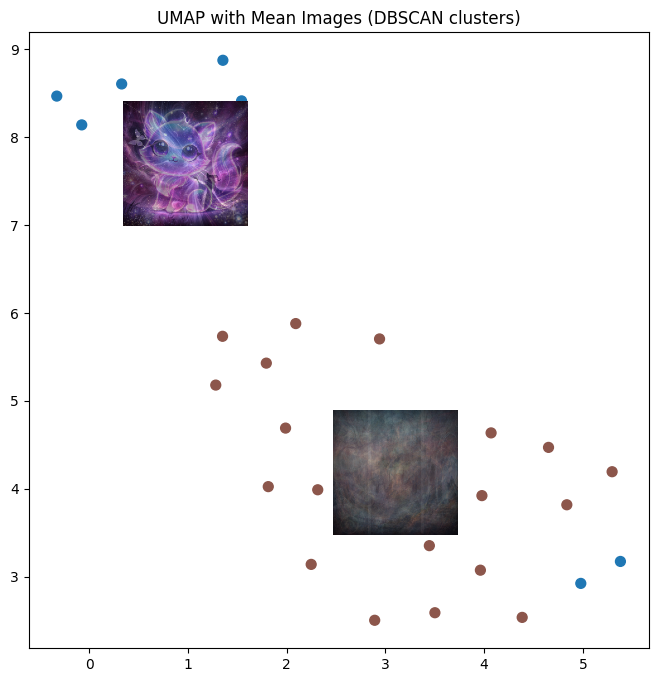

In [59]:


IMG_SIZE = (224, 224)  # size for mean images
unique_labels_db = set(labels)  # labels from DBSCAN

plt.figure(figsize=(8,8))
plt.scatter(embeddings_2d_umap[:,0], embeddings_2d_umap[:,1], c=labels, cmap='tab10', s=50)

for cluster_id in unique_labels_db:
    if cluster_id == -1: 
        continue  # skip noise points

    # Cluster points in UMAP space
    cluster_points = embeddings_2d_umap[[i for i,l in enumerate(labels) if l==cluster_id]]
    centroid = cluster_points.mean(axis=0)
    
    # Compute mean image for the cluster
    cluster_imgs = [filenames[i] for i, l in enumerate(labels) if l == cluster_id]
    sum_img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    for fname in cluster_imgs:
        img_path = os.path.join(pic_dir, fname)
        img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
        sum_img += np.array(img, dtype=np.float32)
    mean_img = (sum_img / len(cluster_imgs)).astype(np.uint8)
    mean_img_pil = Image.fromarray(mean_img)
    
    # Overlay mean image at cluster centroid
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(mean_img_pil, zoom=0.4),
                                        centroid, frameon=False)
    plt.gca().add_artist(imagebox)

plt.title("UMAP with Mean Images (DBSCAN clusters)")
plt.show()


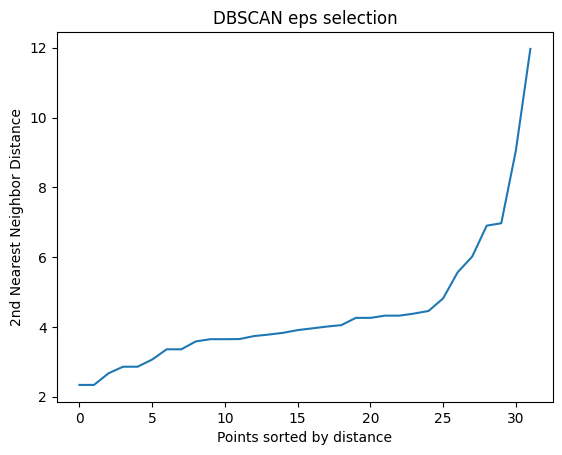

In [ ]:

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(embeddings.numpy())
distances, indices = nbrs.kneighbors(embeddings.numpy())

distances = np.sort(distances[:, 1])  # 2nd nearest neighbor distance
plt.plot(distances)
plt.ylabel("2nd Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.title("DBSCAN eps selection")
plt.show()


In [39]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# embeddings = [32, 768]
# Compute Gaussian affinity matrix
sigma = 10.0
dists = pairwise_distances(embeddings.numpy())
affinity = np.exp(-dists**2 / (2 * sigma**2))

# Run spectral clustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
labels_spec = spectral.fit_predict(affinity)

# Check assignments
for fname, label in zip(filenames, labels_spec):
    print(f"{fname} -> Cluster {label}")


DALL·E 2024-12-06 17.57.38 - A lavender-purple cyber cat that is cute, soft, and fluffy, with a glowing, futuristic aesthetic. The cat has a sleek but fluffy fur texture that emit.webp -> Cluster 2
Gemini_Generated_Image_rm63btrm63btrm63.jpeg -> Cluster 0
DALL·E 2024-10-01 16.19.13 - A realistic and majestic sunset in the mountains, reminiscent of a scene from Game of Thrones, without any dragons. The mountains are rugged, dark, an.webp -> Cluster 0
DALL·E 2024-09-01 13.16.33 - A cyber world at night, full of fascinating future technology. The cityscape is illuminated with vibrant purple, blue, and other futuristic lighting. .webp -> Cluster 0
Sujasa Eerie.jpg -> Cluster 0
17db6e0a-4d3c-460a-a36a-3b2b2db13dbf.webp -> Cluster 0
85197756-ef30-42b7-be3e-c317dcc03476.webp -> Cluster 0
DALL·E 2024-10-31 16.29.57 - A cute, fluffy cartoon cat designed to look like sushi. The cat has a playful, rounded body shape with light pastel fur that resembles rice. It has se.webp -> Cluster 1
DALL·E 202

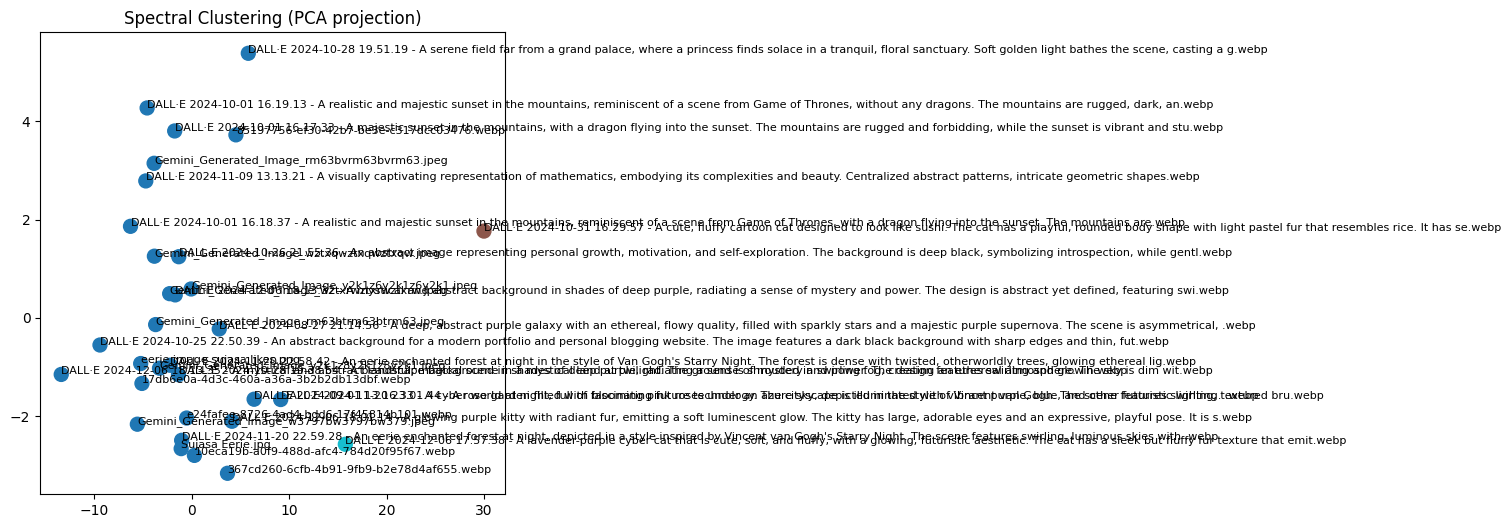

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


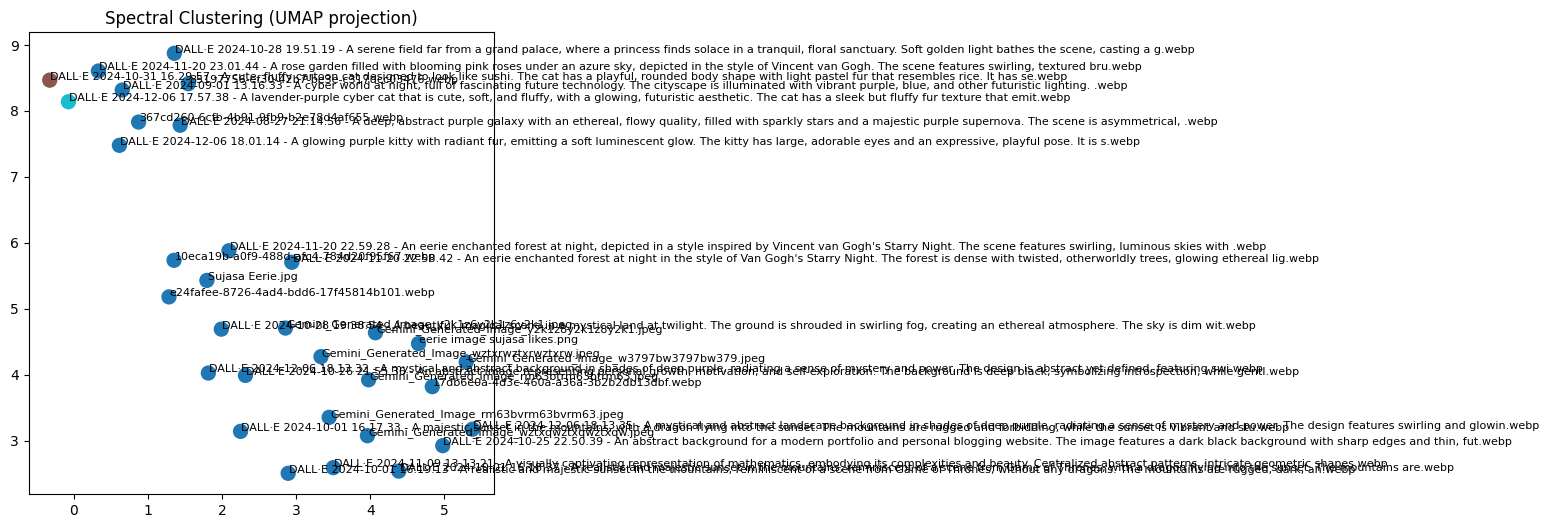

In [50]:


# --- PCA projection ---
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings.numpy())

plt.figure(figsize=(6,6))
plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1], c=labels_spec, cmap='tab10', s=100)
for i, fname in enumerate(filenames):
    plt.text(embeddings_2d_pca[i,0]+0.01, embeddings_2d_pca[i,1]+0.01, fname, fontsize=8)
plt.title("Spectral Clustering (PCA projection)")
plt.show()

# --- UMAP projection ---
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
embeddings_2d_umap = reducer.fit_transform(embeddings.numpy())

plt.figure(figsize=(6,6))
plt.scatter(embeddings_2d_umap[:,0], embeddings_2d_umap[:,1], c=labels_spec, cmap='tab10', s=100)
for i, fname in enumerate(filenames):
    plt.text(embeddings_2d_umap[i,0]+0.01, embeddings_2d_umap[i,1]+0.01, fname, fontsize=8)
plt.title("Spectral Clustering (UMAP projection)")
plt.show()


In [51]:
import numpy as np
from PIL import Image
import os

IMG_SIZE = (224, 224)  # standardize all images

unique_labels = set(labels_spec)

for cluster_id in unique_labels:
    if cluster_id == -1:
        continue  # skip noise if any

    # Collect images in this cluster
    cluster_imgs = [filenames[i] for i, l in enumerate(labels_spec) if l == cluster_id]
    
    sum_img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    
    for fname in cluster_imgs:
        img_path = os.path.join(pic_dir, fname)
        img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
        sum_img += np.array(img, dtype=np.float32)
    
    mean_img = (sum_img / len(cluster_imgs)).astype(np.uint8)
    mean_img_pil = Image.fromarray(mean_img)
    
    mean_img_pil.show(title=f"Cluster {cluster_id} Mean Image")


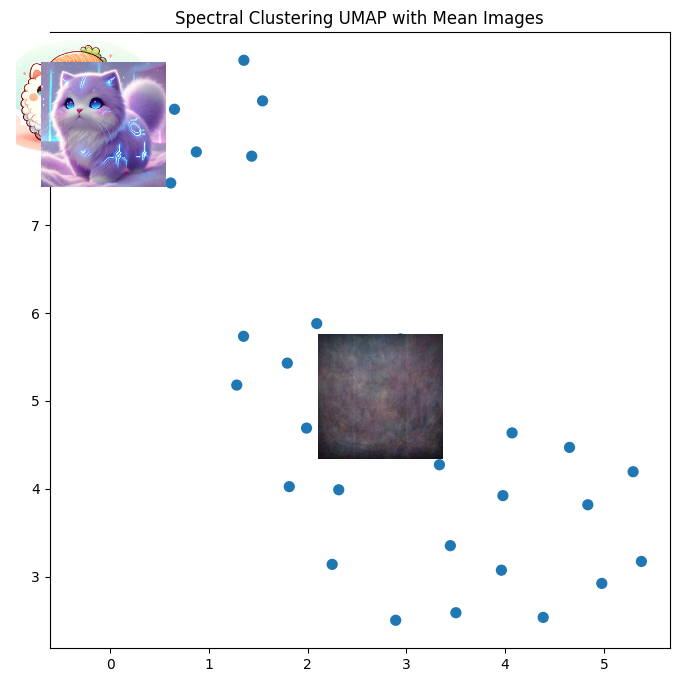

In [52]:

plt.figure(figsize=(8,8))
plt.scatter(embeddings_2d_umap[:,0], embeddings_2d_umap[:,1], c=labels_spec, cmap='tab10', s=50)

for cluster_id in unique_labels:
    if cluster_id == -1: continue
    # Cluster centroid in UMAP space
    cluster_points = embeddings_2d_umap[[i for i,l in enumerate(labels_spec) if l==cluster_id]]
    centroid = cluster_points.mean(axis=0)
    
    # Convert mean image to displayable object
    cluster_imgs = [filenames[i] for i, l in enumerate(labels_spec) if l == cluster_id]
    sum_img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    for fname in cluster_imgs:
        img_path = os.path.join(pic_dir, fname)
        img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
        sum_img += np.array(img, dtype=np.float32)
    mean_img = (sum_img / len(cluster_imgs)).astype(np.uint8)
    mean_img_pil = Image.fromarray(mean_img)
    
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(mean_img_pil, zoom=0.4),
                                        centroid, frameon=False)
    plt.gca().add_artist(imagebox)

plt.title("Spectral Clustering UMAP with Mean Images")
plt.show()
